## Self-adaptive Sampling Method Test
We will test the self-adaptive sampling method proposed by ourselves in following Possion equation case:
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [3]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

# Define our deep Ritz network model
class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [4]:
# Draw plots of approximate solutions
def draw_graph(mod):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    plt.savefig("loss_1.eps")
    plt.show()

In [3]:
# Calculate the relative loss
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t = t + 1
    
    return mmm / t

In [5]:
# U_groundtruth = 1/4*(x^2+y^2)-1/4
# take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

In [ ]:
gamma = 100
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
lr1 = 0.01
lr2 = 0.005
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr2)
ccc = 1

# Training
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    
    grid = np.linspace(0, 2*pi, 200)
    n2 = 1
    
    # Self-adaptive sampling
    for i in range(200):
        if i < 199:
            grid_i_1 = grid[i+1]
        else:
            grid_i_1 = grid[0]
        th = (grid[i] + grid_i_1) / 2
        x1 = np.zeros(m)
        x1[0] = cos(th)
        x1[1] = sin(th)
        x1 = torch.tensor(x1).float()
        yy = model(x1)
        t = floor(abs(yy)*100)
        for theta in np.linspace(grid[i], grid_i_1, t):
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = model(x_input)
            regularization += y**2 
            n2 = n2 + 1
    regularization *= mm / n2
    
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    #print(k, " loss to real solution: ", cal_loss(model))
    
    loss += regularization
    
    #and step the optimizer
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss.backward()
    if k < 270:
        optimizer1.step()
    else:
        optimizer2.step()

/home/samim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


(0, ' epoch, loss: ', array(-0.23625502, dtype=float32))
(0, ' epoch, regularization loss: ', array(0., dtype=float32))
(1, ' epoch, loss: ', array(-0.32251132, dtype=float32))
(1, ' epoch, regularization loss: ', array(0.5557145, dtype=float32))
(2, ' epoch, loss: ', array(-0.3291053, dtype=float32))
(2, ' epoch, regularization loss: ', array(0.5000195, dtype=float32))
(3, ' epoch, loss: ', array(-0.31163737, dtype=float32))
(3, ' epoch, regularization loss: ', array(0.41668335, dtype=float32))
(4, ' epoch, loss: ', array(-0.28443927, dtype=float32))
(4, ' epoch, regularization loss: ', array(0.33376768, dtype=float32))
(5, ' epoch, loss: ', array(-0.25479093, dtype=float32))
(5, ' epoch, regularization loss: ', array(0.26051894, dtype=float32))
(6, ' epoch, loss: ', array(-0.2261193, dtype=float32))
(6, ' epoch, regularization loss: ', array(0.2027223, dtype=float32))
(7, ' epoch, loss: ', array(-0.20127544, dtype=float32))
(7, ' epoch, regularization loss: ', array(0.15847804, dtype

In [7]:
#cal_loss(model)

0.17629128315632753

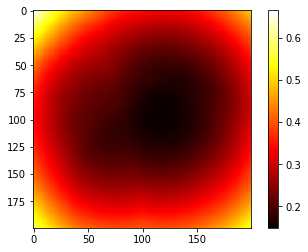

In [7]:
draw_graph(model)

In [10]:
# Draw plots of approximate solutions
def draw_real_solution_graph():
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    plt.savefig("u_1.eps")
    plt.show()

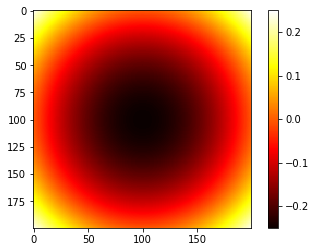

In [11]:
draw_real_solution_graph()